<a href="https://colab.research.google.com/github/Ali-Fartout/Kaggle/blob/main/TPS_Jan_2022/TPS_jan_2022_Moderl_to_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requierment

In [86]:

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c tabular-playground-series-jan-2022

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [87]:
import zipfile

zipfile = zipfile.ZipFile('/content/train.csv.zip','r')
zipfile.extractall()
zipfile.close()

In [88]:
import pandas as pd
import numpy as np

train = pd.read_csv('/content/train.csv',parse_dates=['date'])
test = pd.read_csv('/content/test.csv',parse_dates=['date'])
sub = pd.read_csv('/content/sample_submission.csv')

# Model to EDA (catboost)

In [89]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [90]:
!pip install catboost

In [91]:
def Encoder(data,feature):
  items = data[feature].value_counts().index.tolist()
  for index_itr,item in enumerate(data[feature]):                                
      enc_val = items.index(item)
      data[feature].iloc[index_itr] = enc_val
  return data


In [92]:
def engineering(data):
  data['year'] = data.date.dt.year
  data['day'] = data.date.dt.day
  data['month'] = data.date.dt.month
  for col in ['country','store','product']:
    Encoder(data,col)
    
  return data

train = engineering(train)
test = engineering(test)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
X = train.copy()
y = X.pop('num_sold')

num = int(len(X)*0.8)

# Potential time-dependent data, so no random splitting
X_train = X.iloc[:num, :]
X_test  = X.iloc[num:, :]

y_train = y.iloc[:num]
y_test  = y.iloc[num:]

In [94]:
from catboost import CatBoostRegressor

catboost_reg = CatBoostRegressor(loss_function= 'RMSE',
                             iterations = 200,
                             learning_rate=0.1, 
                             depth = 6,
                             )

catboost_reg.fit(X_train,y_train,logging_level='Silent')
pred = catboost_reg.predict(X_test)

In [95]:
!pip install shap
import shap

In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 129.45
R2: 0.80


In [97]:
catboost_reg.feature_importances_

array([1.39288138e+00, 1.41935989e+00, 1.35229005e+01, 1.50762782e+01,
       5.82404032e+01, 1.99466409e-02, 2.88303107e+00, 7.44519911e+00])

In [98]:
X_train.columns

Index(['row_id', 'date', 'country', 'store', 'product', 'year', 'day',
       'month'],
      dtype='object')

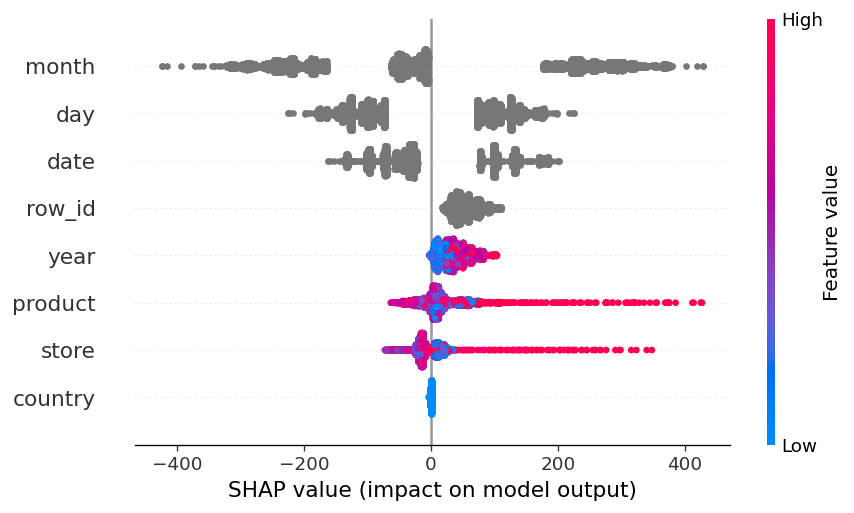

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6), dpi = 120)
explainer = shap.TreeExplainer(catboost_reg)
importance = pd.Series(catboost_reg.feature_importances_,
                       index = X_train.columns)

importance = importance.sort_values() 

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values,
                  X_test,
                  feature_names = importance.index)

* product, score, month, country are important features

# Correlations

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Text(0.5, 1.0, 'Correlation : Pearson')

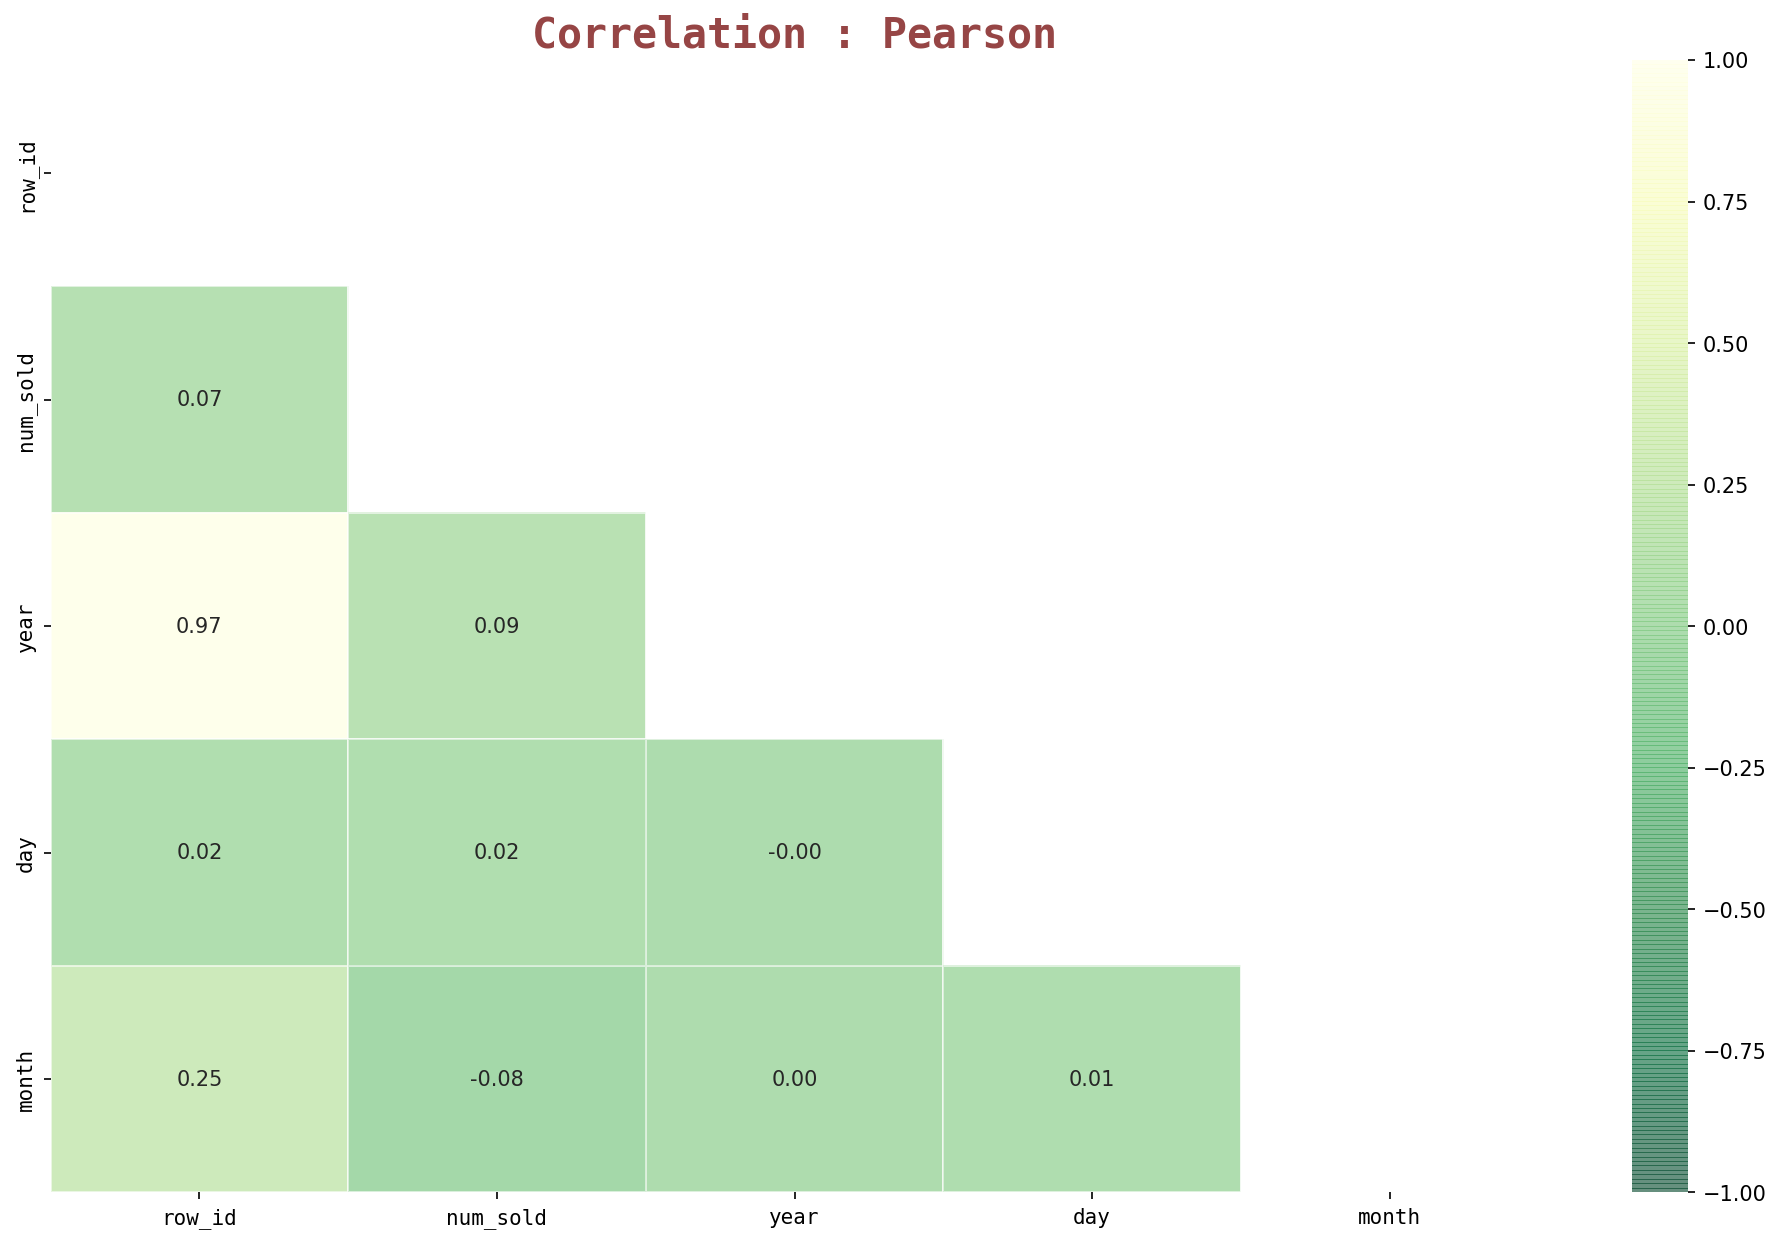

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
temp = train.copy()

cols = temp.columns
plt.figure(figsize = (16, 10), dpi = 150)

corr = temp.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(corr,
            mask = mask,
            cmap = 'YlGn_r',
            vmin=-1, vmax=1,
            annot = True,
            linewidths = 0.5,
            fmt = ".2f",
            alpha = 0.6)

hfont = {'fontname':'monospace'}
plt.xticks(**hfont)
plt.yticks(**hfont)

plt.title('Correlation : Pearson',
          family = 'monospace',
          fontsize = 20,
          weight = 'semibold',
          color = '#964545')

